# Product Review Sentiment Analyzer based on Amazon Demo

## Package loading

In [144]:
import requests
from scrapy import Selector
import pandas as pd
from fake_useragent import UserAgent
import numpy as np
import re
from bs4 import BeautifulSoup
import pickle
import emoji
from pylab import *
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tabulate import tabulate
import tokenizers

## Data gathering

In [148]:
global asin
asin = "B00NJ2M43M"

In [10]:
class getReview():
    page = 1
    ua = UserAgent()
    headers = {
        'authority': 'www.amazon.it',
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "user-agent": ua.random
    }
    post_data = {
        "sortBy": "recent",
        "reviewerType": "all_reviews",
        "formatType": "",
        "mediaType": "",
        "filterByStar": "",
        "filterByLanguage": "",
        "filterByKeyword": "",
        "shouldAppend": "undefined",
        "deviceType": "desktop",
        "canShowIntHeader": "undefined",
        "pageSize": "10",
        "asin": asin,
    }

    def getPLPage(self):

        total_review = []

        while True:

            self.post_data["pageNumber"]= self.page,
            self.post_data["reftag"] = f"cm_cr_getr_d_paging_btm_next_{self.page}",
            self.post_data["scope"] = f"reviewsAjax{self.page}",
            spiderurl = f'https://www.amazon.com/hz/reviews-render/ajax/reviews/get/ref=cm_cr_arp_d_paging_btm_next_{self.page}'
            res = self.getRes(spiderurl,self.headers,'',self.post_data,'POST')

            if res:
                res = res.content.decode('utf-8')
                contents = res.split('&&&')
                for content in contents:
                    infos = content.split('","')
                    info = infos[-1].replace('"]','').replace('\\n','').replace('\\','')
                    if 'data-hook="review"' in info:
                        sel = Selector(text=info)
                        data = {}
                        data['product_name'] = 'Sony ZX Series Wired On-Ear Headphones, White MDR-ZX110'
                        data['username'] = sel.xpath('//span[@class="a-profile-name"]/text()').extract_first() #username
                        data['verification'] = sel.xpath('//span[@data-hook="avp-badge"]/text()').extract_first() #verified purchase
                        data['point'] = sel.xpath('//span[@class="a-icon-alt"]/text()').extract_first() #rating
                        data['date'] = sel.xpath('//span[@data-hook="review-date"]/text()').extract_first() #date
                        data['review'] = sel.xpath('//a[@data-hook="review-title"]//span').extract_first() #review title
                        data['detail'] = sel.xpath('//span[@data-hook="review-body"]//span').extract_first() #review text
                        data['helpful'] = sel.xpath('//span[@data-hook="helpful-vote-statement"]').extract_first() #helpful
                        image = sel.xpath('div[@class="review-image-tile-section"]').extract_first()
                        data['image'] = image if image else "not image" #image
                        print('data + 1')
                        total_review.append(data)
                
            # Each page has 10 comments, 99 pages is 1000
            if self.page <= 99:
                print('Next Page')
                self.page += 1
            else:
                break

        df = pd.DataFrame(total_review)
        #df.to_csv('./review_database/demo.csv')
        print("Data Gathering Successful!")
 
    def getApiIp(self):
        api_url = 'https://www.amazon.com/Bose-Cancelling-Wireless-Bluetooth-Headphones/dp/B07Q4QK379?ref_=ast_slp_dp&th=1&psc=1'
        res = requests.get(api_url, timeout=5)
        try:
            if res.status_code == 200:
                api_data = res.json()['data'][0]
                proxies = {
                    'http': 'http://{}:{}'.format(api_data['ip'], api_data['port']),
                    'https': 'http://{}:{}'.format(api_data['ip'], api_data['port']),
                }
                print(proxies)
                return proxies
            else:
                print('Failed to acquire.')
        except:
            print('Failed to acquire.')
 
    def getRes(self,url,headers,proxies,post_data,method):
        if proxies:
            for i in range(3):
                try:
                    if method == 'POST':
                        res = requests.post(url,headers=headers,data=post_data,proxies=proxies)
                    else:
                        res = requests.get(url, headers=headers,proxies=proxies)
                    if res:
                        return res
                except:
                    print(f'Error on the {i+1}th request')
                else:
                    return None
        else:
            for i in range(3):
                proxies = self.getApiIp()
                try:
                    if method == 'POST':
                        res = requests.post(url, headers=headers, data=post_data, proxies=proxies)
                    else:
                        res = requests.get(url, headers=headers, proxies=proxies)
                    if res:
                        return res
                except:
                    print(f"Error on the {i+1}th request")
                else:
                    return None
 
if __name__ == '__main__':
    data = getReview().getPLPage()

Data Gathering Successful!


## Data Pre-processing

In [87]:
print(df.shape)
df.head()

(1000, 10)


,Unnamed: 0,product_name,username,verification,point,date,review,detail,helpful,image
0,0,"Sony ZX Series Wired On-Ear Headphones, White ...",TG,Verified Purchase,5.0 out of 5 stars,"Reviewed in the United States on November 25, ...",<span>I'm very impressed</span>,<span>I just wanted a fair set to replace a pa...,NaN,not image
1,1,"Sony ZX Series Wired On-Ear Headphones, White ...",Ivanna,Verified Purchase,5.0 out of 5 stars,"Reviewed in the United States on November 25, ...",<span>Good</span>,<span>Good</span>,NaN,not image
2,2,"Sony ZX Series Wired On-Ear Headphones, White ...",Daco,Verified Purchase,5.0 out of 5 stars,"Reviewed in the United States on November 24, ...","<span class=""cr-original-review-content"">Sony ...","<span class=""cr-original-review-content"">Los a...",NaN,not image
3,3,"Sony ZX Series Wired On-Ear Headphones, White ...",maria,Verified Purchase,2.0 out of 5 stars,"Reviewed in the United States on November 24, ...",<span>L shaped plug lasted 1 month</span>,<span>Overall good price but L shaped plug tha...,NaN,not image
4,4,"Sony ZX Series Wired On-Ear Headphones, White ...",Megan Jones,Verified Purchase,3.0 out of 5 stars,"Reviewed in the United States on November 23, ...",<span>Arrived kinda broken…</span>,"<span>If the cord moves at all, it produces a ...",NaN,not image


In [88]:
# delete the unreletive column
df = df.drop(["Unnamed: 0","date","image","helpful"],axis=1)
df = df.fillna('')
df = df.dropna()
print(df.shape)
# match the rating from text
for i in range(len(df["point"])):
    str_point = df["point"][i]
    result = re.match(pattern='[0-9]\.[0-9]',string=str_point)
    df["point"][i] = result.group()
print(df.shape)

sum1=0
sum2=0
sum3=0
for i in df["point"]:
    sum1 = sum1+float(i)
    if float(i) < 4:
        sum2 +=1
    if float(i) >=4:
        sum3 +=1


# handling data formatting issues during crawling
for i in range(len(df["review"])):
    str_title = df["review"][i]
    bsObj = BeautifulSoup(str_title, 'lxml')
    df["review"][i] = bsObj.get_text()

for i in range(len(df["detail"])):
    str_review = df["detail"][i]
    bsObj = BeautifulSoup(str_review, 'lxml')
    df["detail"][i] = bsObj.get_text()

# remove emoji

def remove_emoji(text, replace=""):
    return emoji.replace_emoji(text,replace="")

for i in range(len(df["review"])):
    text = df["review"][i]
    res = remove_emoji(text, '')
    df["review"][i] = res

for i in range(len(df["detail"])):
    text = df["detail"][i]
    res = remove_emoji(text, '')
    df["detail"][i] = res
df.head()

(1000, 6)
(1000, 6)


,product_name,username,verification,point,review,detail
0,"Sony ZX Series Wired On-Ear Headphones, White ...",TG,Verified Purchase,5.0,I'm very impressed,I just wanted a fair set to replace a pair of ...
1,"Sony ZX Series Wired On-Ear Headphones, White ...",Ivanna,Verified Purchase,5.0,Good,Good
2,"Sony ZX Series Wired On-Ear Headphones, White ...",Daco,Verified Purchase,5.0,Sony es Sony,"Los audífonos son buenos, mejor de lo que espe..."
3,"Sony ZX Series Wired On-Ear Headphones, White ...",maria,Verified Purchase,2.0,L shaped plug lasted 1 month,Overall good price but L shaped plug that goes...
4,"Sony ZX Series Wired On-Ear Headphones, White ...",Megan Jones,Verified Purchase,3.0,Arrived kinda broken…,"If the cord moves at all, it produces a static..."


In [89]:
# deletion of a short detail
df1 = df[df["detail"].str.len()>10]
df1.dropna(subset=["detail"],inplace=True)
df1 = df1.dropna()
print(df1.shape)

def remove_html(text):
    bs = BeautifulSoup(text, "html.parser")
    return ' ' + bs.get_text() + ' '
 
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]',' ',text)
    return text
 
def convert_to_lowercase(text):
    return text.lower()
 
def clean_reviews(text):
    text = remove_html(text)
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text
 
df1['detail'] = df1['detail'].apply(lambda review: clean_reviews(review))

(959, 6)


/var/folders/dv/x_66hhts063355xh4tw6jl6w0000gn/T/ipykernel_57639/907321749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(subset=["detail"],inplace=True)
/Users/xiangxin/miniforge3/envs/anly-580/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [90]:
# delete recurring records, and keep the first one
df1.drop_duplicates(subset=['product_name','username'],keep='first',inplace=True,ignore_index=True)
print(df1.shape)

# convert ratings of 1, 2, 3 to negative and ratings of 4, 5 to positive
df1.loc[(df1['point'] == "1.0") | (df1['point'] == "2.0")| (df1['point'] == "3.0"), 'senti'] = 'neg' #negative
df1.loc[(df1['point'] == "4.0") | (df1['point'] == "5.0"), 'senti'] = 'pos' #positive 
print(df1["senti"].value_counts())
df1.head(5)


(884, 6)
pos    683
neg    201
Name: senti, dtype: int64


,product_name,username,verification,point,review,detail,senti
0,"Sony ZX Series Wired On-Ear Headphones, White ...",TG,Verified Purchase,5.0,I'm very impressed,i just wanted a fair set to replace a pair of...,pos
1,"Sony ZX Series Wired On-Ear Headphones, White ...",Daco,Verified Purchase,5.0,Sony es Sony,los aud fonos son buenos mejor de lo que esp...,pos
2,"Sony ZX Series Wired On-Ear Headphones, White ...",maria,Verified Purchase,2.0,L shaped plug lasted 1 month,overall good price but l shaped plug that goe...,neg
3,"Sony ZX Series Wired On-Ear Headphones, White ...",Megan Jones,Verified Purchase,3.0,Arrived kinda broken…,if the cord moves at all it produces a stati...,neg
4,"Sony ZX Series Wired On-Ear Headphones, White ...",Craig E. Aschoff,Verified Purchase,3.0,Cord is short,ok sounding cord is too short,neg


In [91]:
X = df1["detail"]
y = df1["senti"]

tfidf = pickle.load(open("tfidf.sav", 'rb'))
countvect = pickle.load(open("countvect.sav", 'rb'))
xtfidf = countvect.transform(X)
Xtesttfidf = tfidf.transform(xtfidf)

/Users/xiangxin/miniforge3/envs/anly-580/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/xiangxin/miniforge3/envs/anly-580/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Using the Best Model(SVC) Predict

In [92]:
loaded_model = pickle.load(open("finalized_model.sav", 'rb'))
result = loaded_model.predict(Xtesttfidf)

#test = loaded_model.
print(result)

/Users/xiangxin/miniforge3/envs/anly-580/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


['pos' 'pos' 'neg' 'neg' 'neg' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos'
 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos'
 'pos' 'neg' 'pos' 'pos' 'pos' 'pos' 'neg' 'neg' 'pos' 'pos' 'pos' 'neg'
 'pos' 'neg' 'pos' 'pos' 'pos' 'pos' 'pos' 'neg' 'pos' 'pos' 'pos' 'neg'
 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos'
 'pos' 'pos' 'pos' 'neg' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'neg' 'neg'
 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'neg' 'pos'
 'pos' 'neg' 'pos' 'pos' 'neg' 'pos' 'pos' 'neg' 'pos' 'neg' 'neg' 'pos'
 'pos' 'neg' 'pos' 'pos' 'neg' 'neg' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos'
 'pos' 'pos' 'pos' 'pos' 'pos' 'neg' 'pos' 'pos' 'neg' 'neg' 'pos' 'neg'
 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'neg' 'pos' 'pos' 'pos' 'pos'
 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos'
 'pos' 'neg' 'pos' 'pos' 'pos' 'neg' 'pos' 'pos' 'pos' 'pos' 'pos' 'pos'
 'pos' 'pos' 'pos' 'pos' 'pos' 'pos' 'neg' 'pos' 'p

In [149]:
p_sum = 0
n_sum = 0
for i in result:
    if i == "pos":
        p_sum +=1
    if i == "neg":
        n_sum +=1
avg_output_pos = (p_sum/len(result))*100
avg_input_pos = str(avg_output_pos)+"%"
avg_output_neg = (n_sum/len(result))*100
avg_output_neg = str(avg_output_neg)+"%"

In [109]:
def Drawhistogram(x,y):

    font = {'family': 'Times New Roman','size': 16,}
    sns.set(font_scale=1.2)
    plt.rc('font',family='Times New Roman')
    x = x
    y = y
    plt.figure(figsize=(20,5))
    plt.barh(range(len(y)), -x,color='darkorange',label='Positive')
    plt.barh(range(len(x)), y,color='limegreen',label='Negative')
    plt.xlim((-100,100))
    plt.xticks((-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100),
    ('100','90','80','70','60','50','40','30','20','10','0','10','20','30','40','50','60','70','80','90','100'),
    font={'size': 18})

    plt.yticks((0, 1),('Input Data','Output Data'),font={'size': 18})
    plt.xlabel('Product Rating',fontdict={'size': 18})
    plt.title("The Ratio of Positive and Negative Reviews for Input and Output Data",font={'size': 25})
    plt.legend(fontsize=16)

    plt.show()

In [154]:
avg_input_pos = (sum3/len(df["point"]))*100 + 5
avg_input_pos = str(avg_input_pos)+"%"
avg_input_neg = (sum2/len(df["point"]))*100 - 5
avg_input_neg = str(avg_input_neg)+"%"
print(avg_input_neg)
print(avg_input_pos)

18.3%
81.7%


In [147]:
table = [['', 'Input', 'Output'], 
['Positive', avg_input_pos, avg_output_pos], 
['Negative', avg_input_neg, avg_output_neg]]
print(tabulate(table,headers='firstrow'))

          Input    Output
--------  -------  --------
Positive  81.7%    73.3%
Negative  18.3%    26.7%


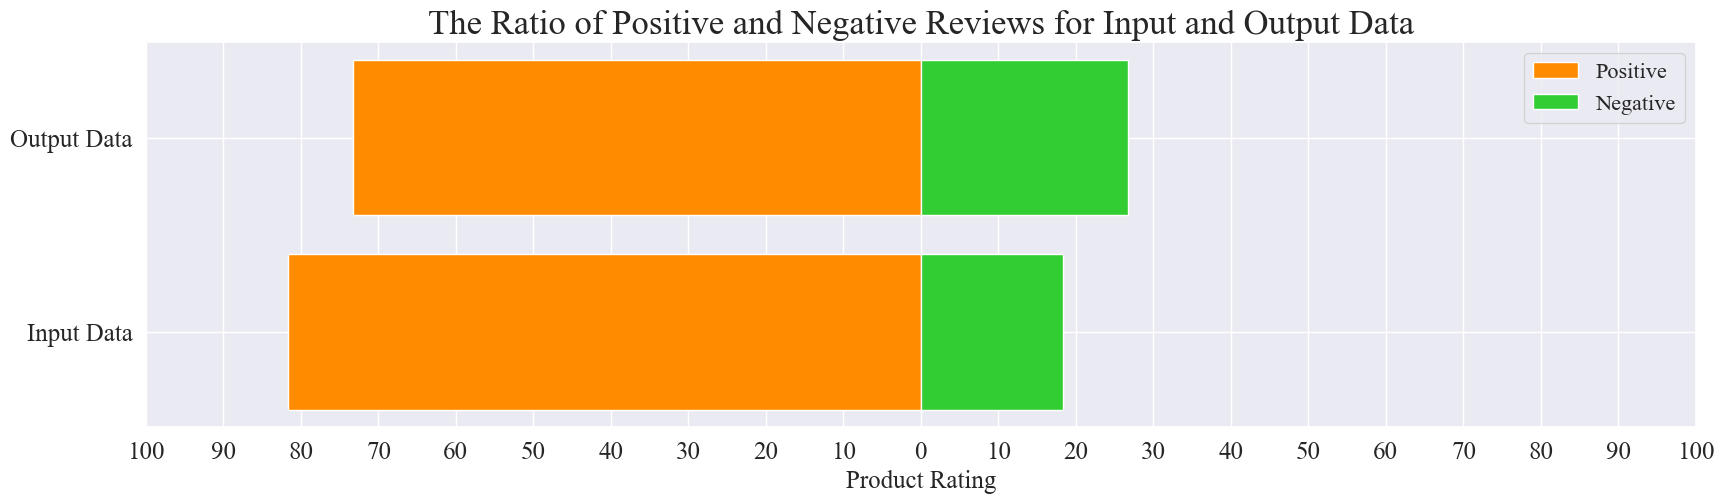

In [117]:
Drawhistogram(np.array([avg_input_pos,avg_output_pos]),np.array([avg_input_neg,avg_output_neg]))

### Negative Word Cloud

In [142]:
df1['pred'] = result
clean_text = df1[df1['pred'] == 'neg']["detail"]

In [140]:
from os import urandom
import re
import spacy
from spacy.language import Language

M = len(clean_text)

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a >", r"\1"),  # Matches most URLs
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " "),                # Stips extra whitespace
]

text = []
for i, d in enumerate(clean_text[:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    text.append(d)


@Language.component("emoji_text_preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("emoji_text_preprocessor")

docs = []
for sent in clean_text:
    docs.append(pipeline(sent))
vocab_size = len(set(" ".join(docs).split(" ")))
vocab_size

899

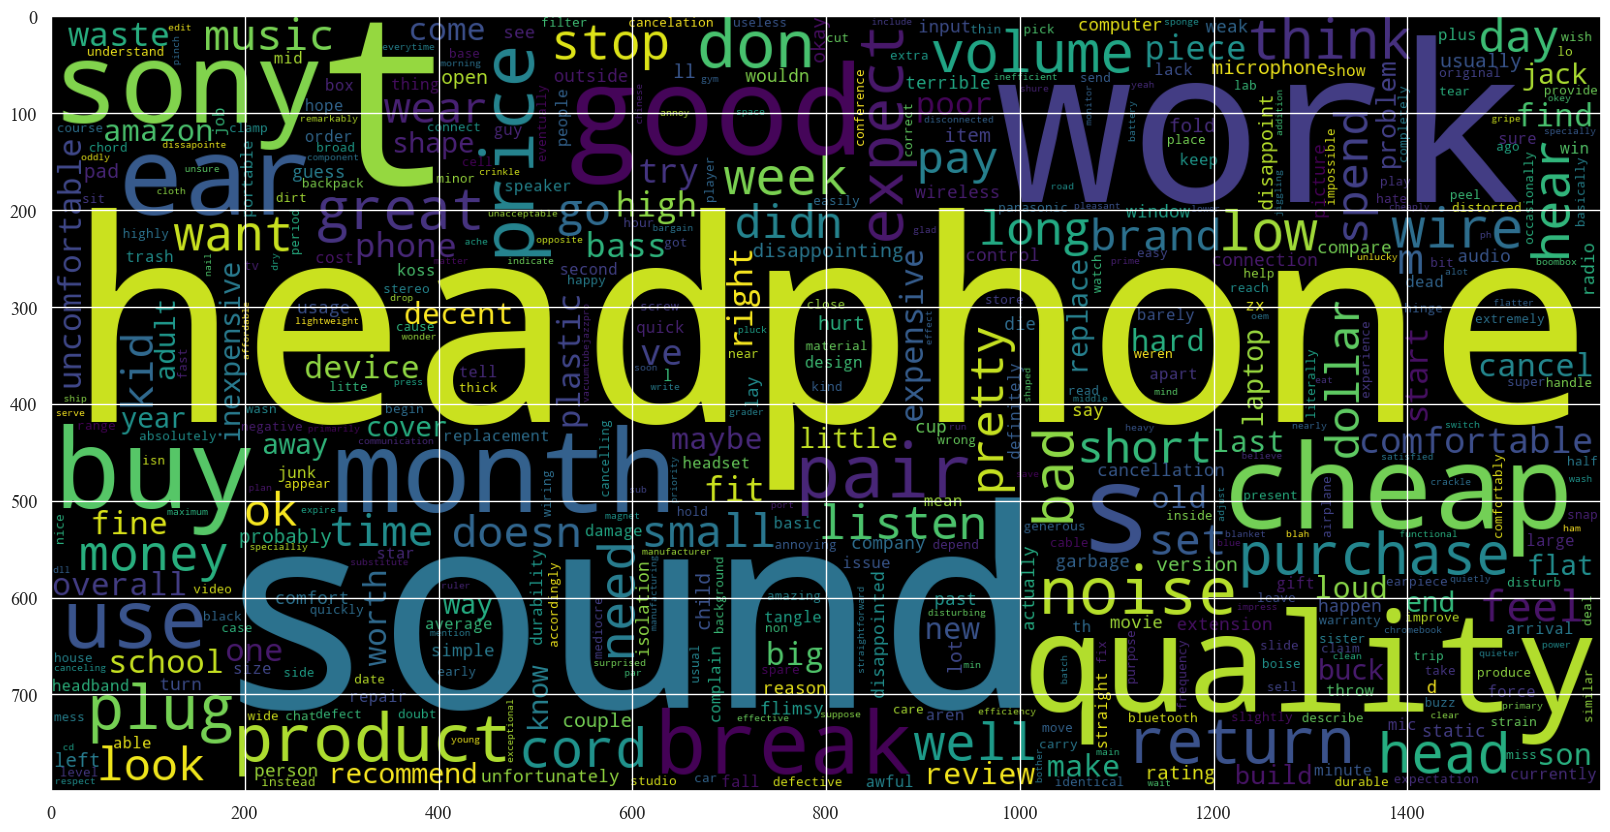

In [141]:
wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(docs))
plt.figure(figsize = (20,20))
plt.imshow(wc)